# Zillow Cluster Project

## Project Overview

In this project, I will be working with a Zillow dataset to create a model that will discover what is driving error in zestimates during the months of May-August, 2017.

## Project Goal

Deliver a Jupyter notebook going through the steps of the data science pipeline
Create clusters in uncovering what the drivers of the error in the zestimate is.
Discover features that contribute to logerror

## Executive Summay

I made some clusters that were statistically significant for difference in log error between them, but they didn't help my model. Even though I was told by recursive feature elimination that they wouldn't work, I still gave it benefit of the doubt.

Clustering based on  did not predict logerror well.


In [21]:
#imports
import os
import pandas as pd
from env import username, host, password 
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from wrangle import get_zillow_data, prepare_zillow, train_validate_test_split, train_validate_test, impute_nulls, split_X_y, standard_scale_data, get_object_cols, get_numeric_X_cols, nulls_by_col, nulls_by_row  
from explore import explore_univariate, create_cluster, create_scatter_plot, get_zillow_heatmap

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import statsmodels.api as sm
from sklearn.metrics import explained_variance_score

# Data Wrangle 

In [22]:
#acquire our Zillow data from CodeUp server by parcel id specifically those that are single unit property values.
df = get_zillow_data()

In [23]:
df.shape

(77575, 68)

### Takeaways

- lots of missing values
- We renamed columns, made dummies, created new features, dropped outliers, and dropped columns and rows that had more than 50% missing values.



In [24]:
df = prepare_zillow(df)

In [25]:
df.shape

(50195, 42)

We are going to split our data into train, validate, and test sets. Impute where we can, and drop the rest of the nulls.



In [26]:
#split into train, validate, test. Our target is logerror
train, validate, test = train_validate_test_split(df, 'logerror', seed=1349)

In [27]:
#return our train, validate, and test sets with calculatedbathnbr, fullbathcnt, regionidcity, regionidzip,censustractandblock
#imputed with most frequent values
train, validate, test = impute_nulls(train, validate, test, strategy='most_frequent', 
                        col_list=['calculatedbathnbr', 'fullbathcnt', 'regionidcity', 'regionidzip', 'censustractandblock'])

In [28]:
#return our train, validate, and test sets with finishedsquarefeet12, lotsizesquarefeet, structuretaxvaluedollarcnt, 
#tax_value, land tax value dollar count, and tax amount imputed with the column's median value. 
train, validate, test = impute_nulls(train, validate, test, strategy='median', 
                        col_list=['finishedsquarefeet12', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 
                                  'tax_value', 'landtaxvaluedollarcnt', 'tax_amount'])

In [29]:
#drop rows with remaining nulls from all of our split sets
train = train.dropna()
validate = validate.dropna()
test = test.dropna()

In [30]:
#assuring there are no more nulls
train.isna().sum().sum() + validate.isna().sum().sum() + test.isna().sum().sum()

0

In [31]:
#split new train, validate, and test into X_train, y_train, X_validate, y_validate, X_test, y_test with logerror as our target
X_train, y_train, X_validate, y_validate, X_test, y_test = split_X_y(train, validate, test, 'logerror')

In [32]:
#get object columns, and numeric columns so we can scale our data
obj_cols = get_object_cols(X_train)
num_cols = get_numeric_X_cols(X_train, obj_cols)

In [33]:
#scale our X_train, X_validate, and X_test with standard scaler
X_train_scaled, X_validate_scaled, X_test_scaled = standard_scale_data(X_train[num_cols],X_validate[num_cols],X_test[num_cols])

### Takeaways:

- Our data is now clean, and split.

- We dropped any rows and columns with more than 50% missing values

- Dropped, filled, or imputed for remaining missing values

- We went from 77,575 rows to 50,195 rows.

- We had 68 columns, now 42.

# Explore

### Hypothesis 

- Logerror is affected by squared feet over 1500 sq ft. 

- Logerror is affected by the number of bedrooms

- Logerror is affected by the number of acres

- Logerror is affected by location

- Logerror is affected by tax value per square feet

- Logerror is effected by a combintaion of house features and also location + land




## Univariate Exploration

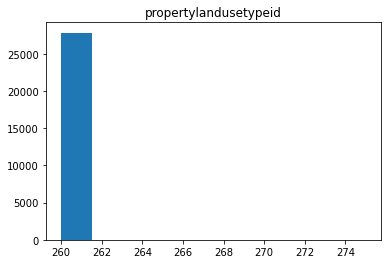

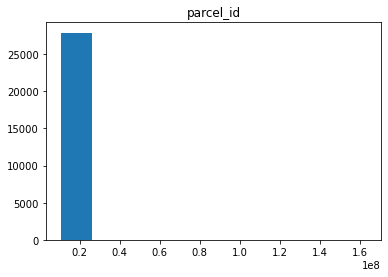

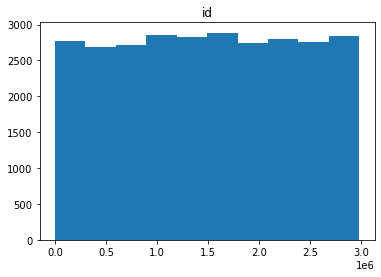

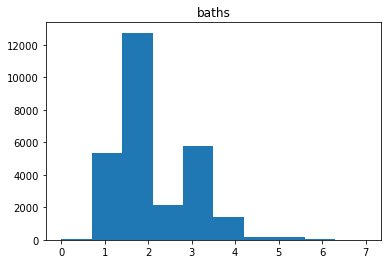

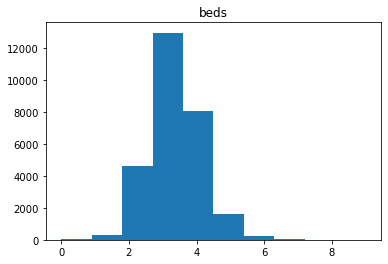

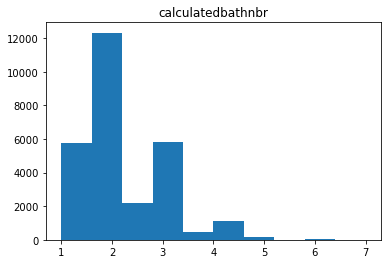

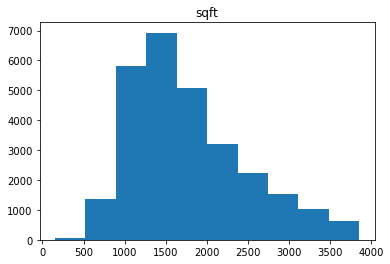

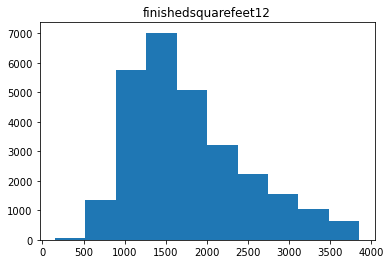

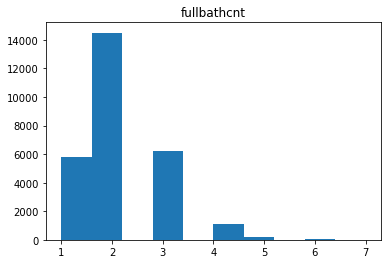

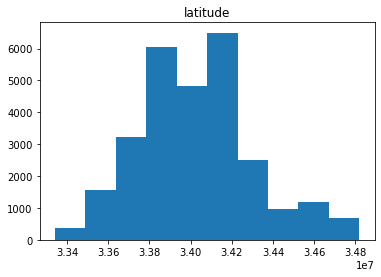

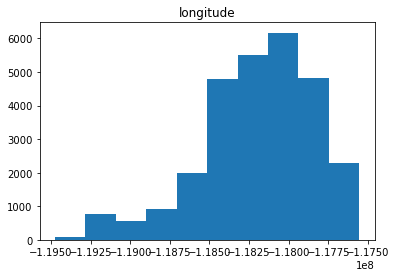

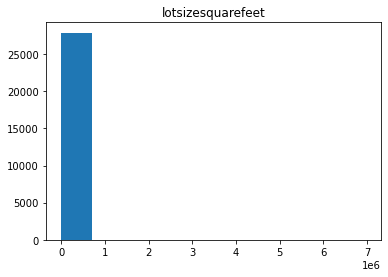

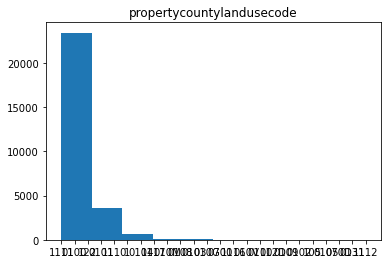

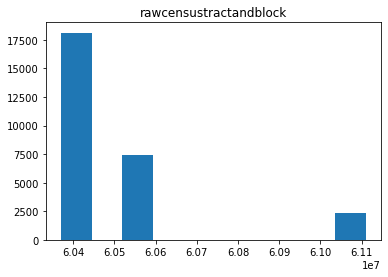

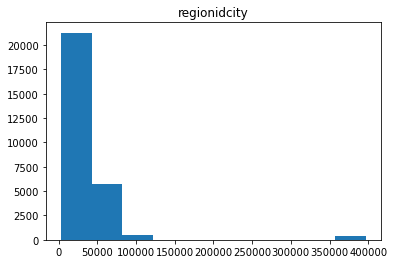

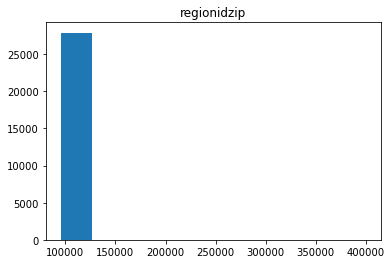

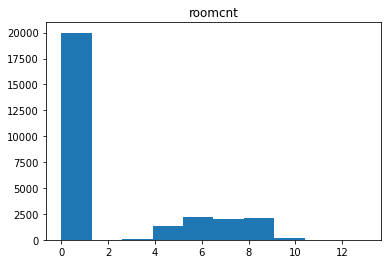

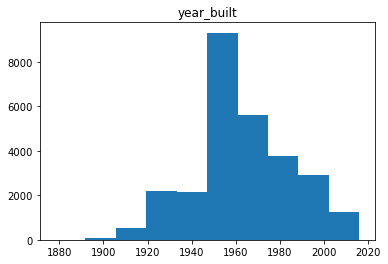

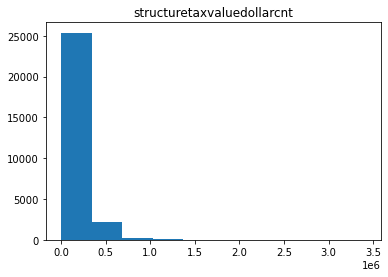

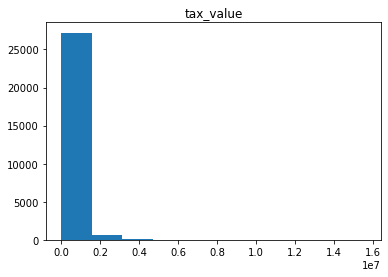

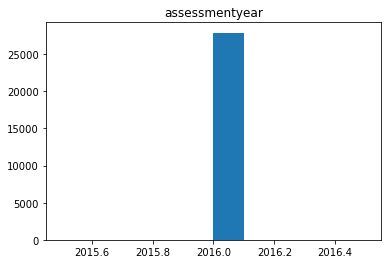

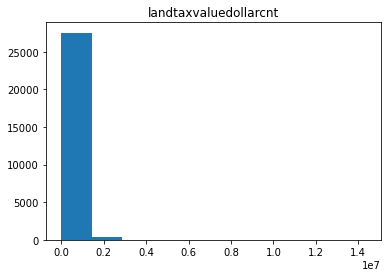

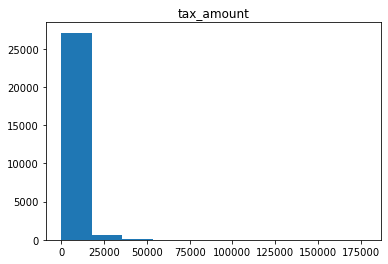

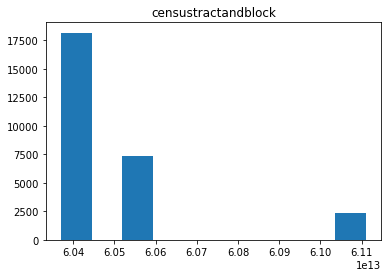

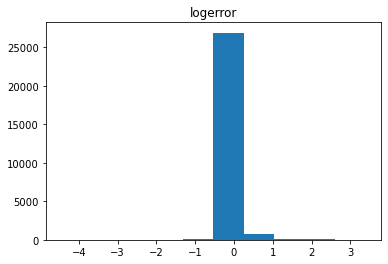

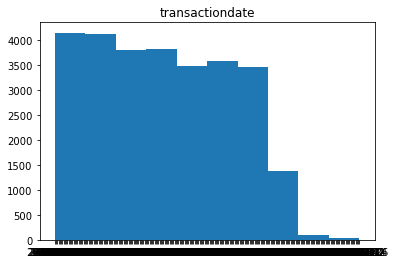

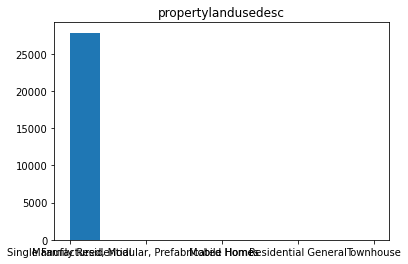

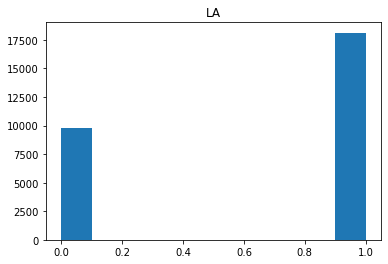

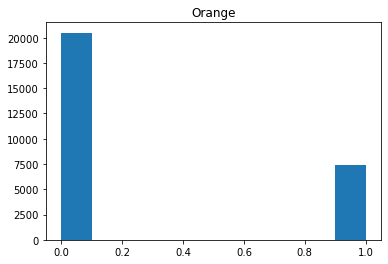

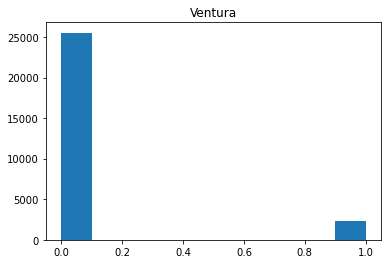

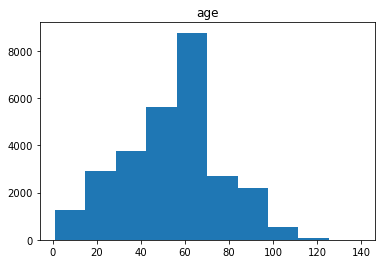

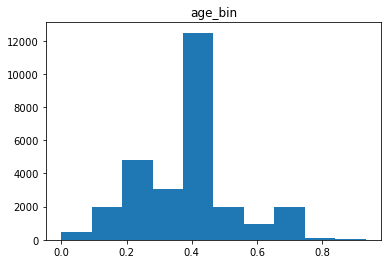

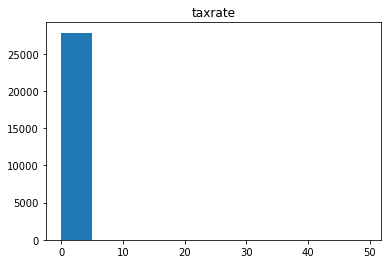

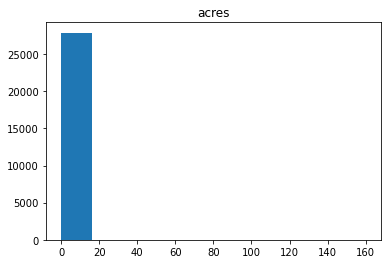

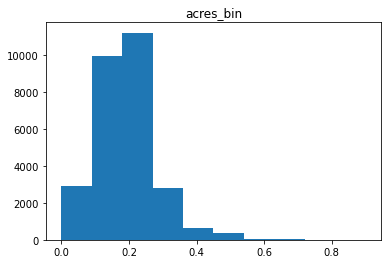

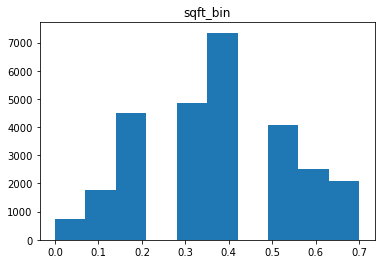

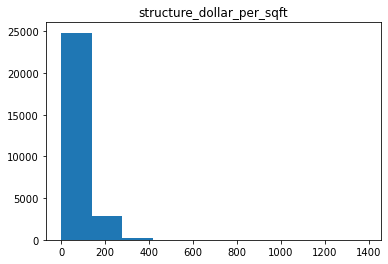

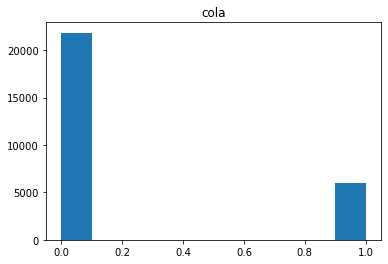

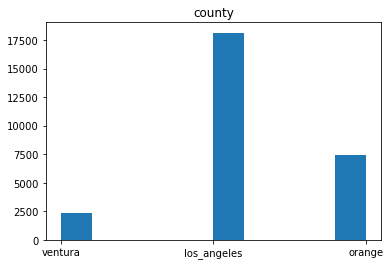

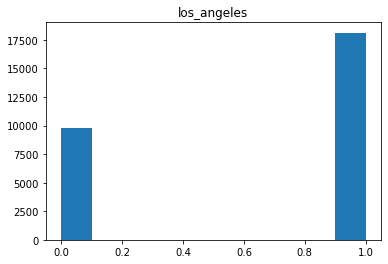

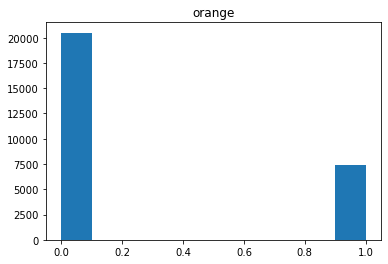

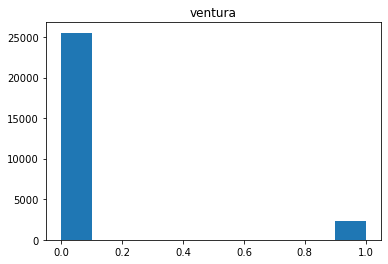

In [34]:
#univariate exploration
for col in train.columns:
    plt.hist(train[col])
    plt.title(col)
    plt.show()

### Deeper dive into univariate 

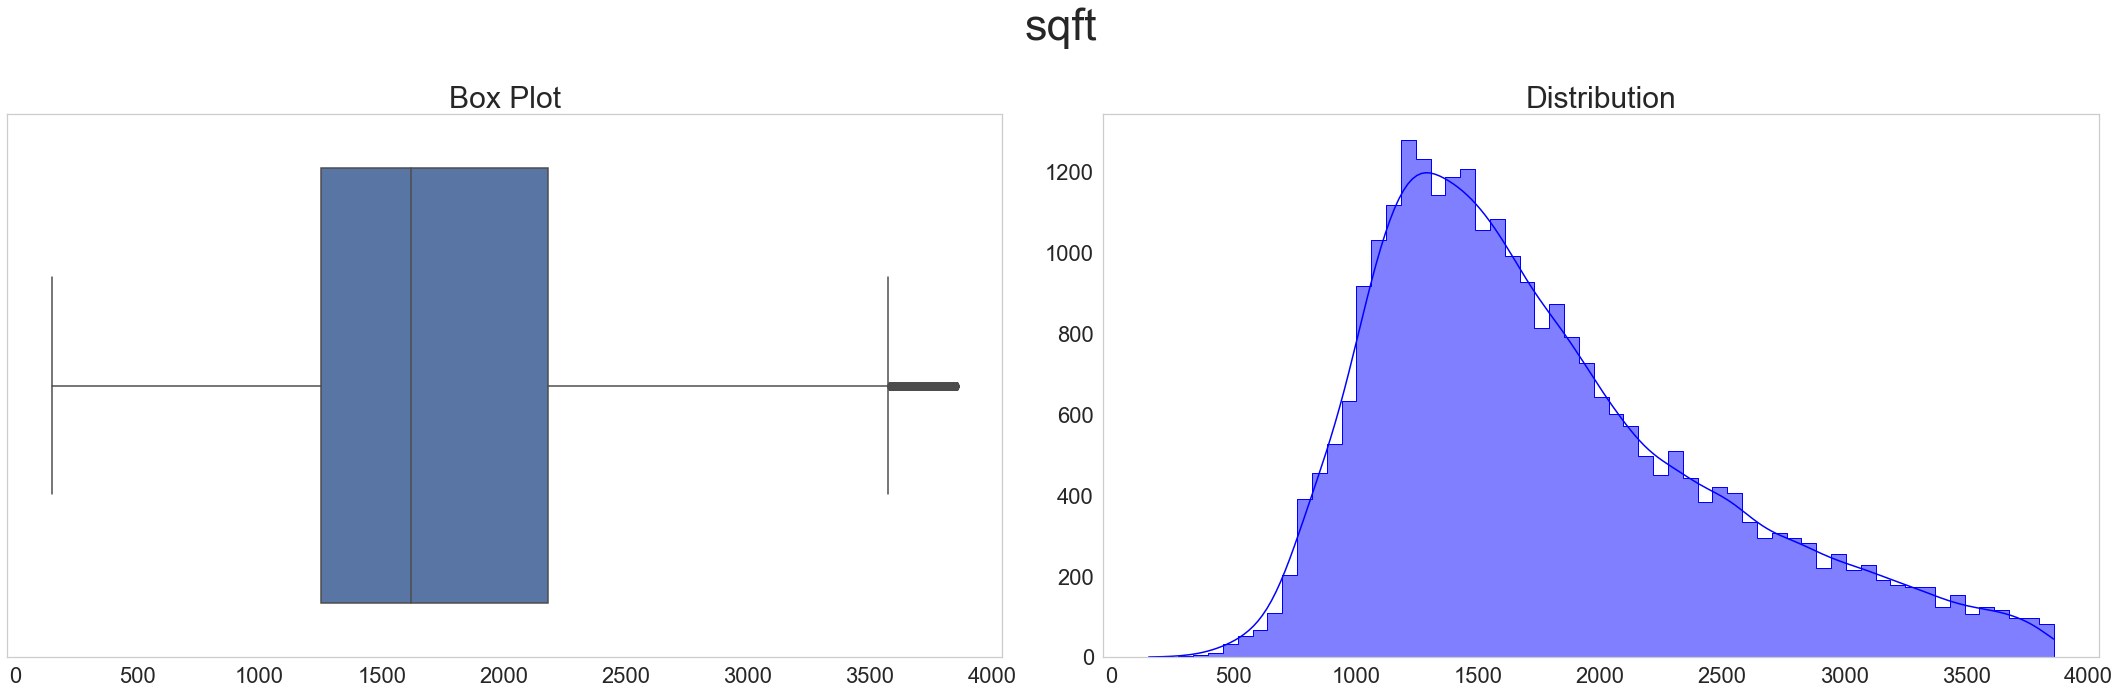

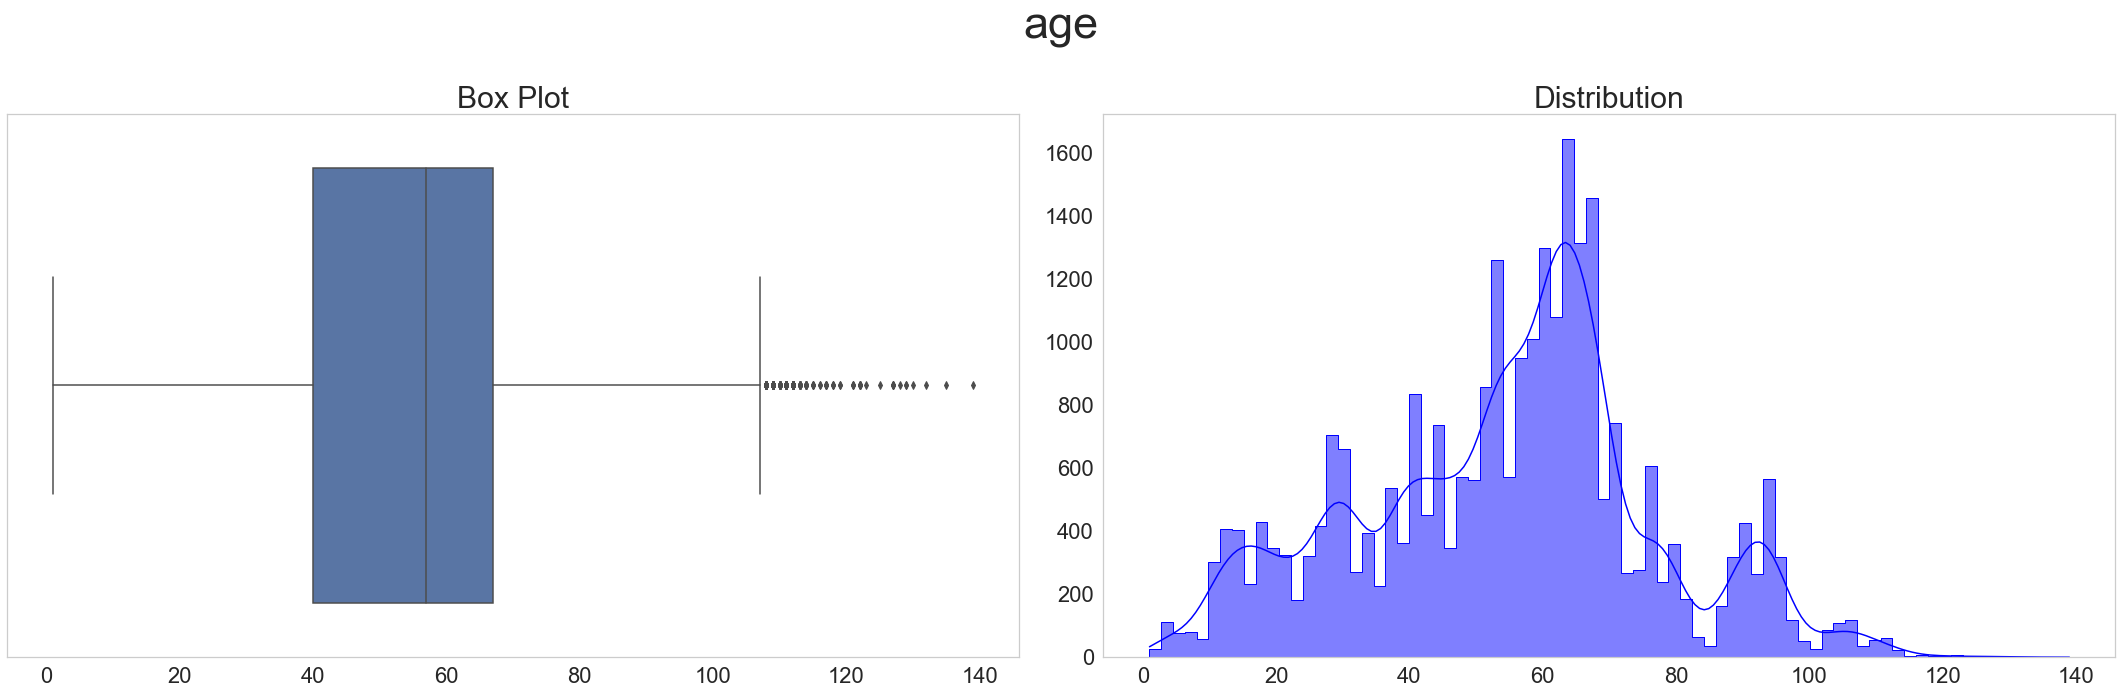

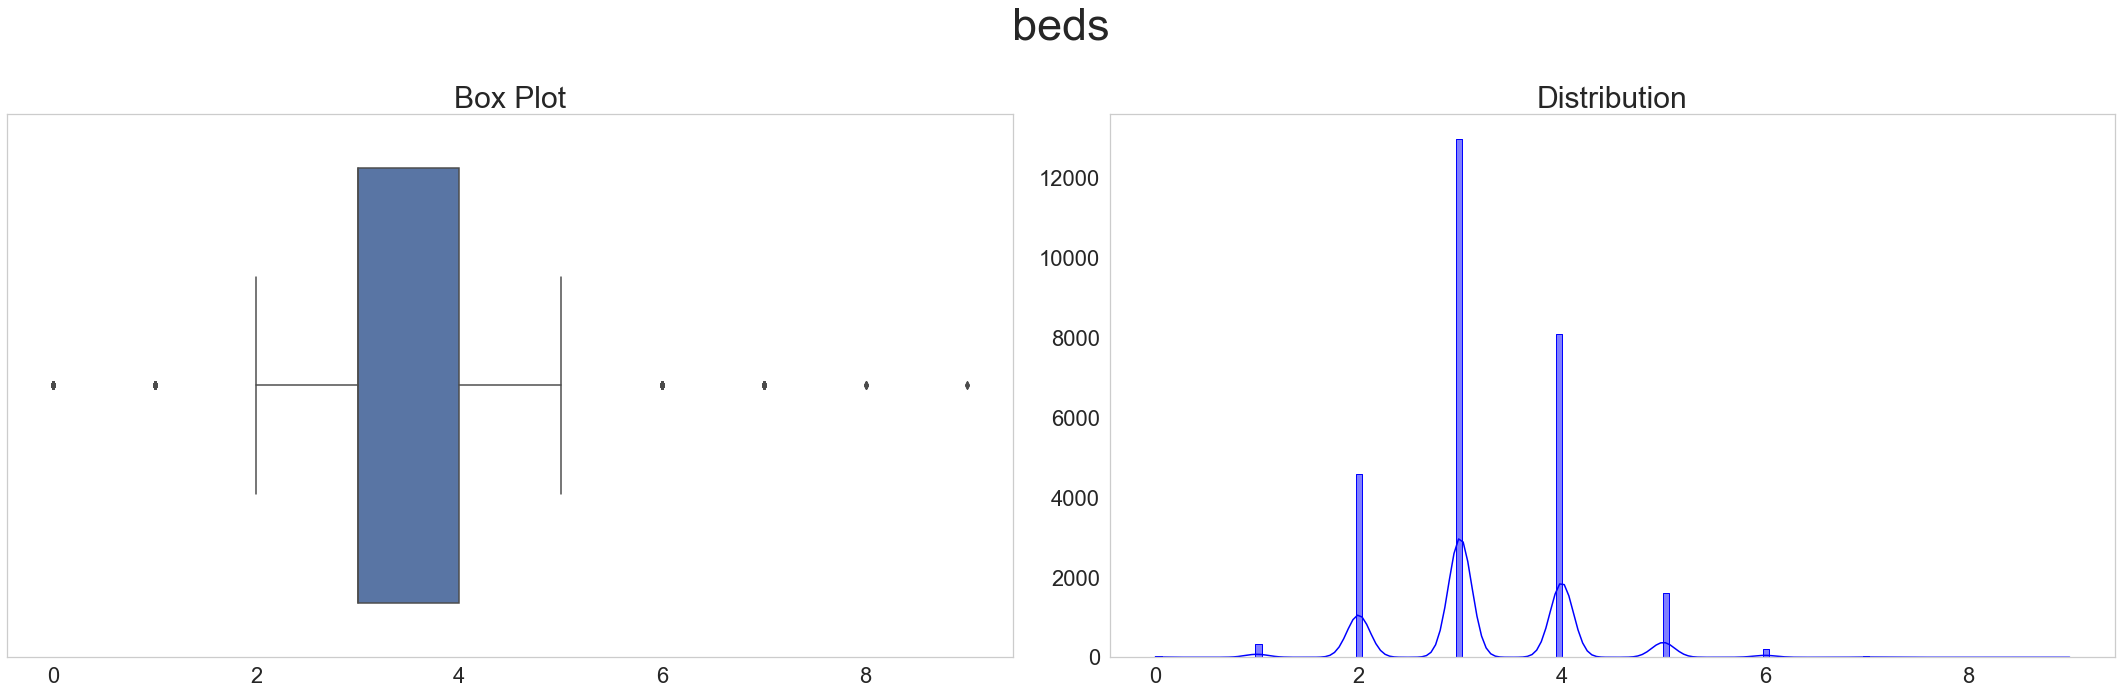

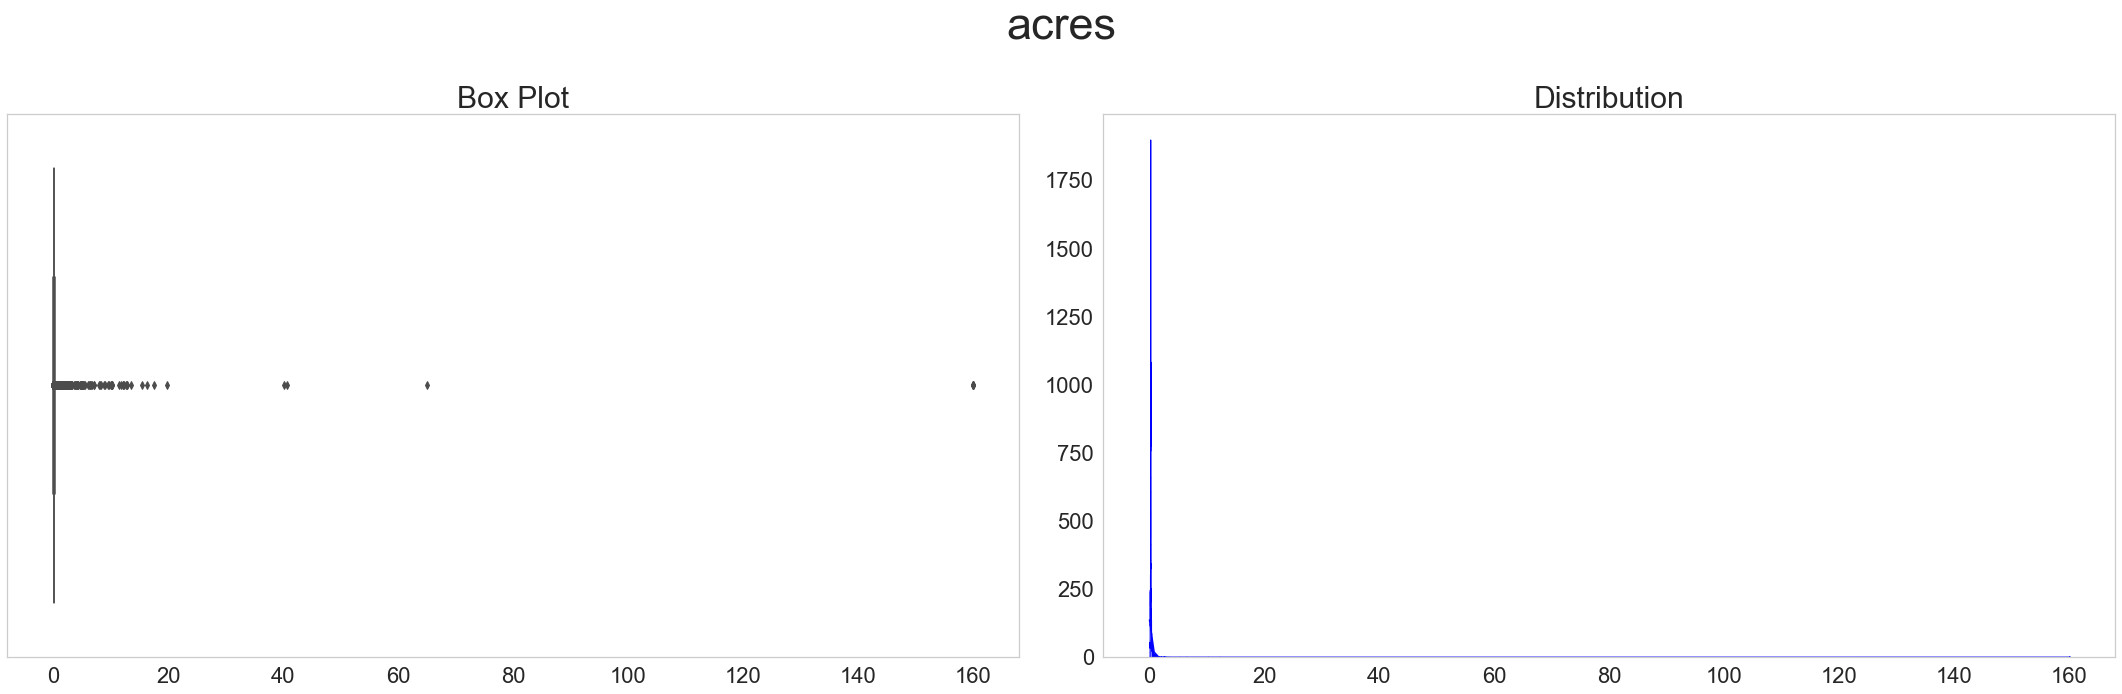

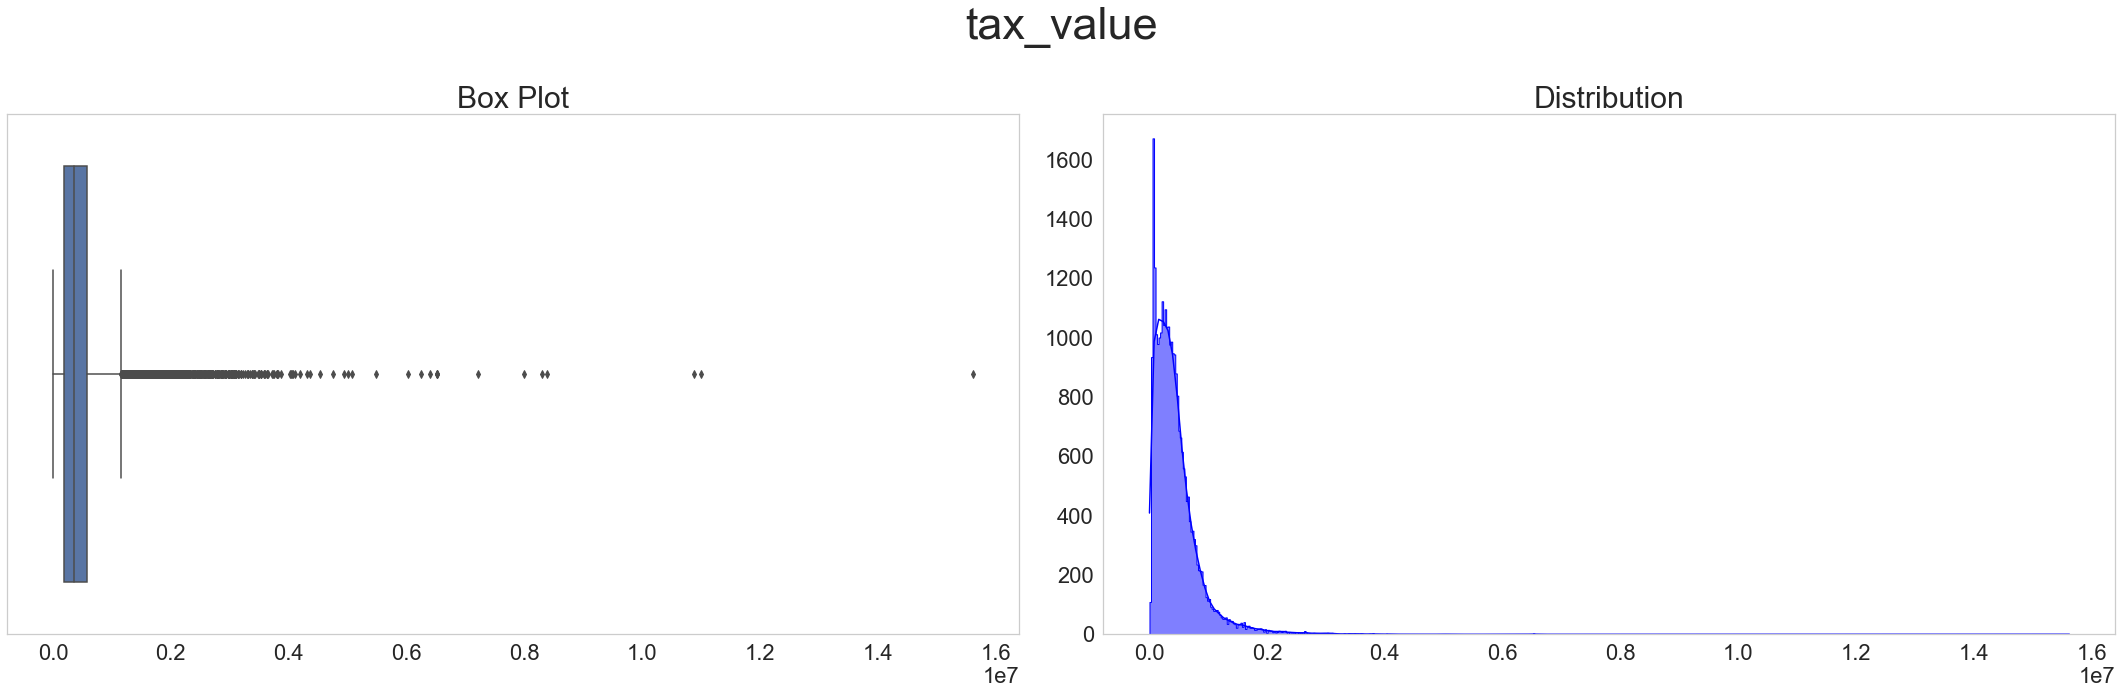

In [37]:
univariate_study = ['sqft','age','beds','acres','tax_value']

for i in univariate_study:
    explore_univariate(train, i)

### Takeaways for Univariate:

- Normal: number of bedrooms, latitude, and age
- Skewed right: tax amount, tax value, sqft, acres_bins
- Skewed left: longitude, year built

## Bivariate Exploration

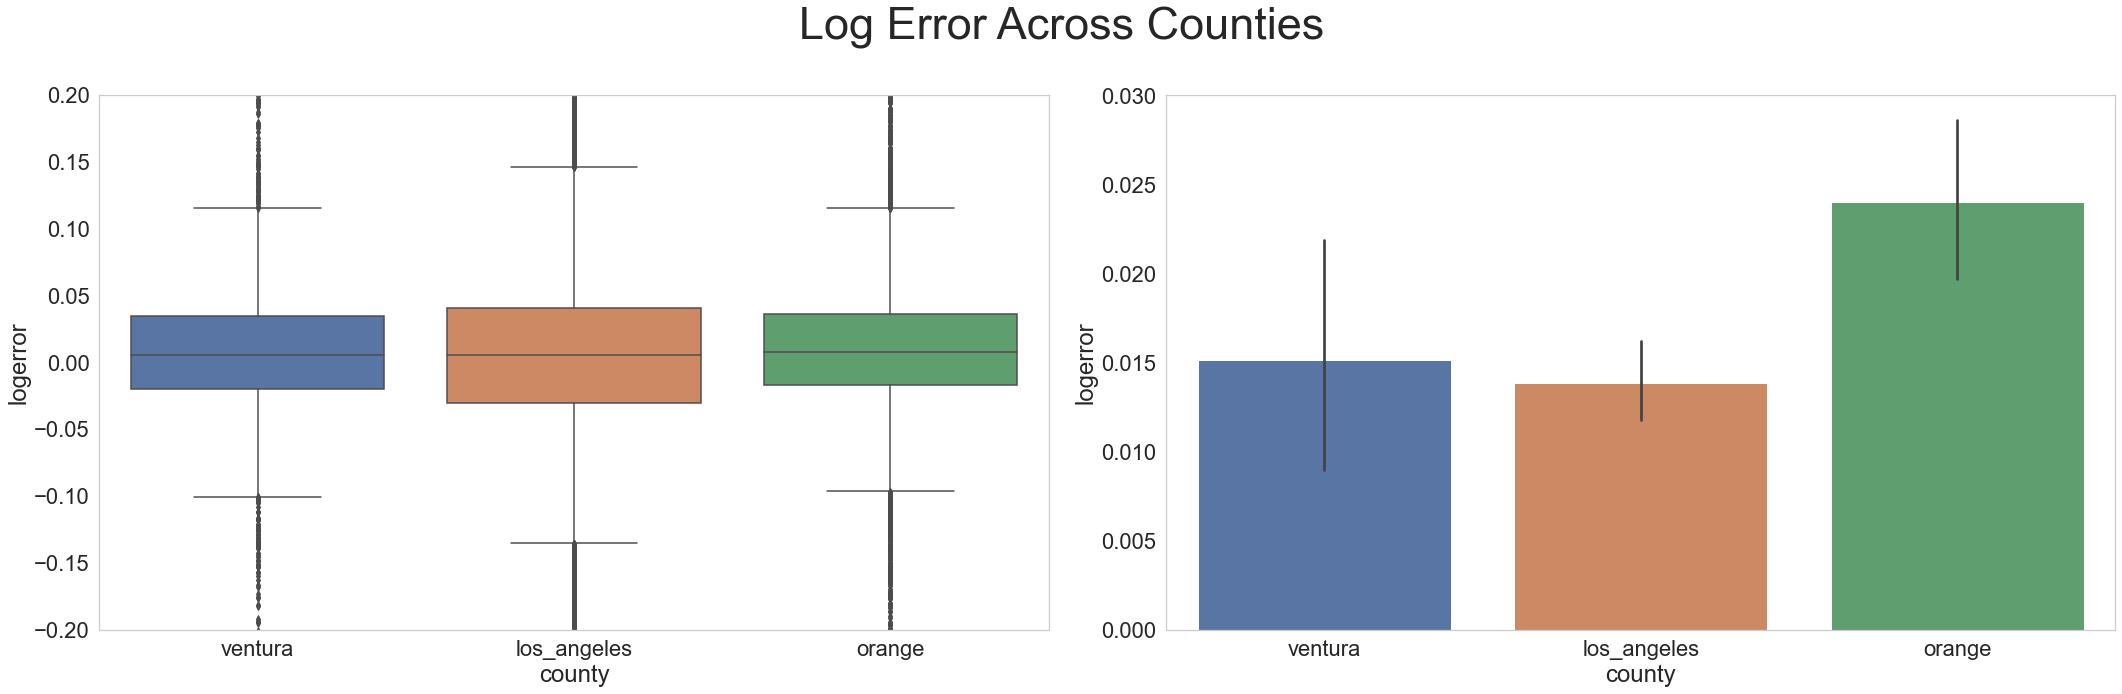

In [38]:
#logerror across counties (LA, Orange, and Ventura)

#set up figure size, font size, and turn off grid.
plt.figure(figsize=(30,10))
sns.set(font_scale = 2)
sns.set_style("whitegrid", {'axes.grid' : False})

#boxplot
plt.subplot(1, 2, 1)
sns.boxplot(train.county, train.logerror)
plt.ylim(-.2, .2)

#barplot
plt.subplot(1, 2, 2)
sns.barplot(data=train, x='county',y='logerror')

#title
plt.suptitle('Log Error Across Counties', fontsize = 45)
plt.tight_layout()
plt.show()

In [41]:
null_hypothesis = "no difference in logerror between ventura county and the other counties"
alternative_hypothesis = "there is a difference in log error between ventura county and other counties"
a = 0.05 #a for alpha 

ventura_logerror=train[train.county=='ventura'].logerror
other_logerror = train[train.county!='ventura'].logerror
t, p = stats.ttest_ind(ventura_logerror, other_logerror)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')
p

Fail to reject null hypothesis that: no difference in logerror between ventura county and the other counties There is not sufficient evidence to reject it.


0.6547545848346378

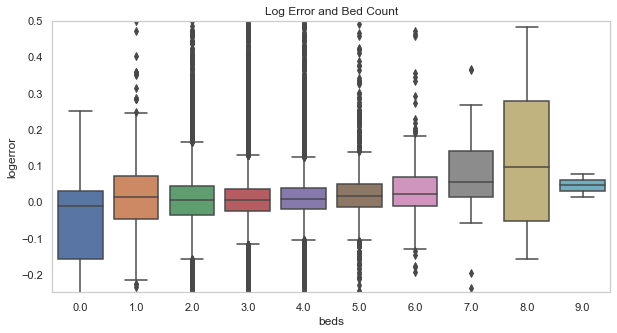

In [43]:
#Log error and number of beds
plt.figure(figsize=(10,5))
sns.set(font_scale = 1)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.boxplot(train.beds, train.logerror)
plt.title('Log Error and Bed Count')
plt.ylim(-.25, .50)
plt.show()

In [45]:
null_hypothesis = "no difference in logerror between properties with 2 beds or less, or more beds"
alternative_hypothesis = "there is a difference in logerror between properties with 2 beds or less, or more beds"
a = 0.05 #a for alpha 

two_or_less_beds=train[train.beds<=2].logerror
more_than_two_beds = train[train.beds>2].logerror
t, p = stats.ttest_ind(two_or_less_beds, more_than_two_beds)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')
p

Reject null hypothesis that: no difference in logerror between properties with 2 beds or less, or more beds
There is evidence to suggest: there is a difference in logerror between properties with 2 beds or less, or more beds


0.004748326729948461

Acres and LogError


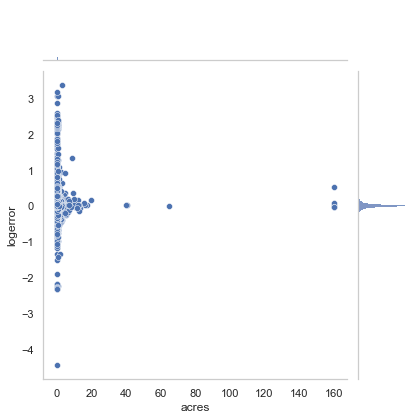

In [46]:
print('Acres and LogError')
sns.jointplot(x='acres', y='logerror', data=train)
plt.xlabel('Sqft')
plt.ylabel('Log Error')
plt.show()

In [47]:
null_hypothesis = "no difference in logerror between properties 2 acres or less, or with more acres"
alternative_hypothesis = "there is a difference in logerror between properties 2 acres or less, or with more acres"
a = 0.05 #a for alpha 

More_land=train[train.acres<=2].logerror
less_land = train[train.acres>2].logerror
t, p = stats.ttest_ind(More_land, less_land)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')
p

Reject null hypothesis that: no difference in logerror between properties 2 acres or less, or with more acres
There is evidence to suggest: there is a difference in logerror between properties 2 acres or less, or with more acres


0.008352201683554049

Sqft and LogError


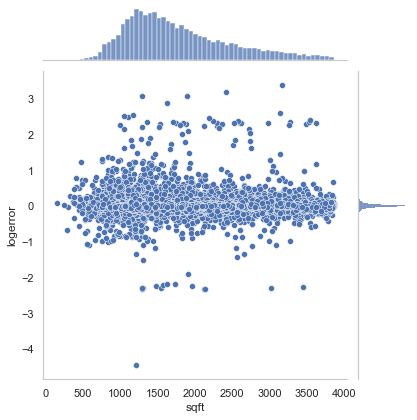

In [48]:
print('Sqft and LogError')
sns.jointplot(x='sqft', y='logerror', data=train)
plt.xlabel('Sqft')
plt.ylabel('Log Error')
plt.show()

In [60]:
null_hypothesis = "no difference in logerror between properties 1500 sqft or less, or with more square footage"
alternative_hypothesis = "there is a difference in logerror between properties 1500 sqft or less, or with more square footage"
a = 0.05 #a for alpha 

house=train[train.sqft<=1500].logerror
tiny_house = train[train.sqft>1500].logerror
t, p = stats.ttest_ind(house, tiny_house)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')
p

Fail to reject null hypothesis that: no difference in logerror between properties 1500 sqft or less, or with more square footage There is not sufficient evidence to reject it.


0.06017459161798919

In [61]:
null_hypothesis = "no difference in logerror between properties 1700 sqft or less, or with more square footage"
alternative_hypothesis = "there is a difference in logerror between properties 1700 sqft or less, or with more square footage"
a = 0.05 #a for alpha 

house=train[train.sqft<=1700].logerror
tiny_house = train[train.sqft>1700].logerror
t, p = stats.ttest_ind(house, tiny_house)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')
p

Reject null hypothesis that: no difference in logerror between properties 1700 sqft or less, or with more square footage
There is evidence to suggest: there is a difference in logerror between properties 1700 sqft or less, or with more square footage


0.008869571304895416

<AxesSubplot:title={'center':'Feautures Correlating with Log Error'}>

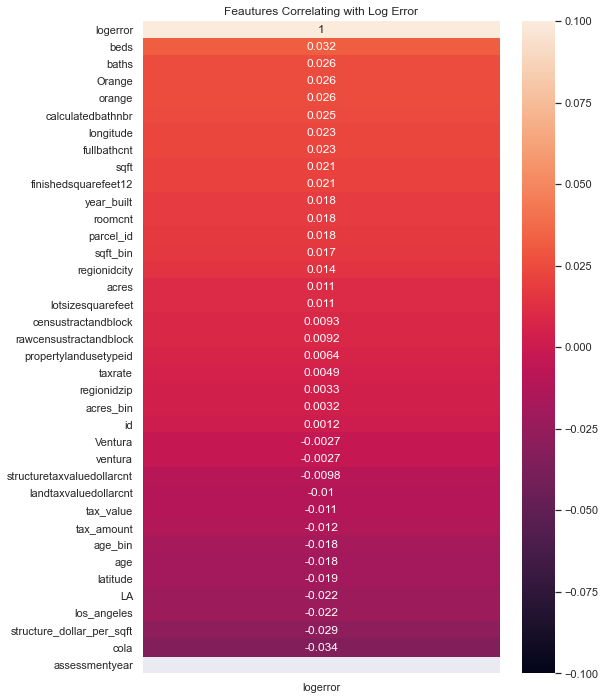

In [51]:
#let's look at a heatmap to see what features correlate with log error.
get_zillow_heatmap(train)

### Takeaways:

- Log error spans a wide spectrum
- No features are strongly correlated with log error

## Multivariate Exploration

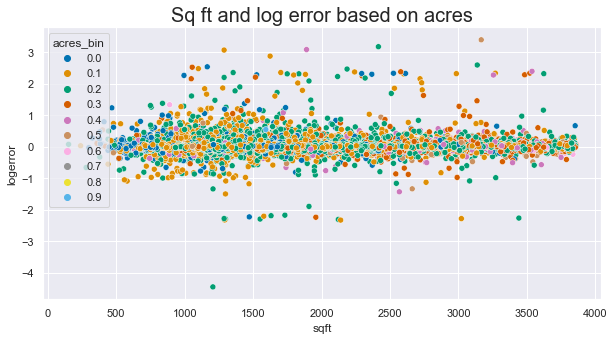

In [54]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='sqft',y='logerror',data=train,hue='acres_bin', palette='colorblind')
plt.title('Sq ft and log error based on acres', fontsize = 20)
plt.show()

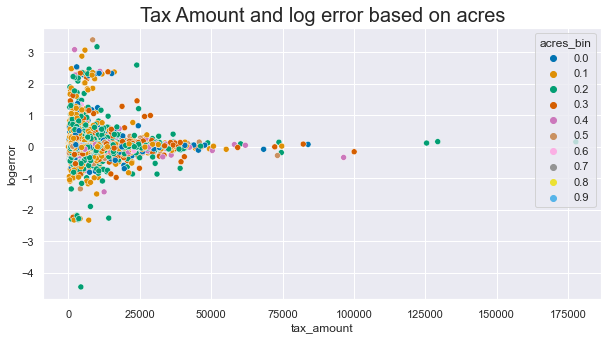

In [55]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='tax_amount',y='logerror',data=train,hue='acres_bin', palette='colorblind')
plt.title('Tax Amount and log error based on acres', fontsize = 20)
plt.show()

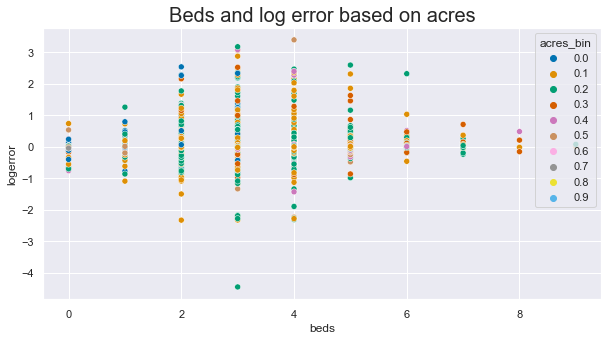

In [56]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='beds',y='logerror',data=train,hue='acres_bin', palette='colorblind')
plt.title('Beds and log error based on acres', fontsize = 20)
plt.show()

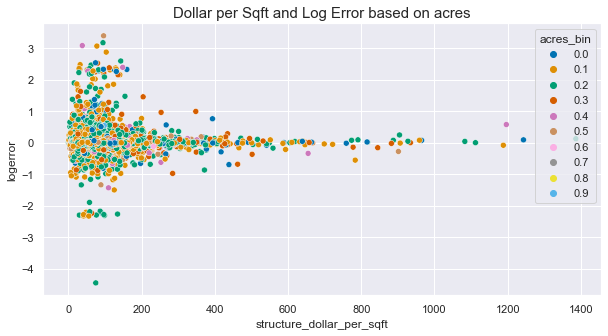

In [57]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='structure_dollar_per_sqft',y='logerror',data=train,hue='acres_bin', palette='colorblind')
plt.title('Dollar per Sqft and Log Error based on acres', fontsize=15)
plt.show()

Clusters based on acres and square footage


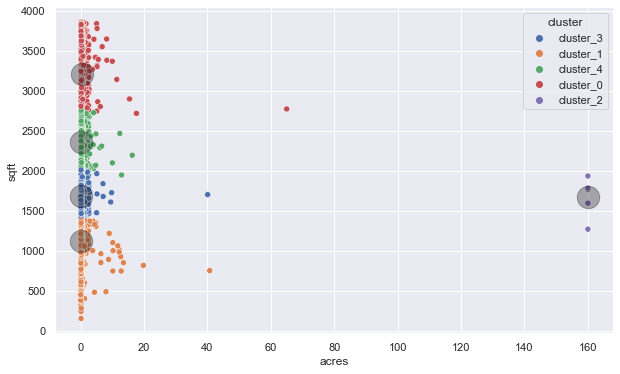

In [58]:
X = train[['acres', 'sqft']]
df, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 5)
create_scatter_plot('acres','sqft',train,kmeans, X_scaled, scaler)
print('Clusters based on acres and square footage')

### Exploration Takeaways Pre-Clustering:

- Log error is affected by property age, price per square foot, number of bedrooms, acreage, and square footage over 1700
- Visually appears that Orange county has the most variance in log error
- Heatmap suggests none of the features (on their own) are strongly correlated to logerror.


## Clustering
We're going to set a = .05

Null Hypthesis: There is no difference in log error between homes based on tax value and square footage.

Alternative Hypothesis: There is a difference in log error between homes based on tax value and square footage.

Clusters based on Tax Value and square footage


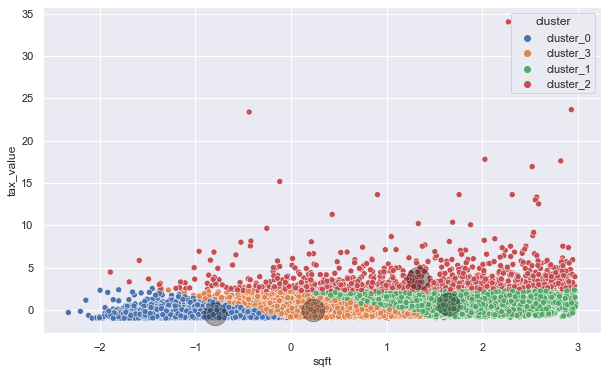

In [62]:
#Let's look at tax value and square footage
X = X_train_scaled[['sqft', 'tax_value']]
X_train_scaled, X_scaled, scaler, kmeans, centroids = create_cluster(X_train_scaled, X, 4)
create_scatter_plot('sqft','tax_value',X_train_scaled,kmeans, X_scaled, scaler)
print('Clusters based on Tax Value and square footage')



In [63]:
#add our predictions to train so we can test for significance
train['cluster'] = kmeans.predict(X_scaled)

In [64]:
#assign clusters
cluster0 = train[train.cluster == 0].logerror # small house house, low tax value
cluster1 = train[train.cluster == 1].logerror # medium to large house, mid tax value
cluster2 = train[train.cluster == 2].logerror # Large house, high tax value
cluster3 = train[train.cluster == 3].logerror # small to medium house, mid tax value


In [65]:
#Statistically significant differences in log error means between these groups? ANOVA stats test
from scipy.stats import f_oneway

f, p = f_oneway(cluster0,cluster1,cluster2,cluster3)
f,p

(4.764007049874968, 0.0025374943962340355)

The p value is significant. We reject the null hypothesis and observed there is a difference between homes based on tax value and square footage

Null Hypthesis: There is no difference in log error between homes based on their longitude and latitude

Alternative Hypothesis: There is a difference in log error between homes based their longitude and latitude

NameError: name 'ax' is not defined

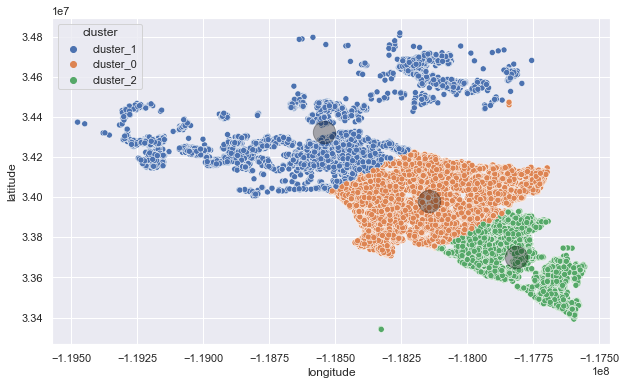

In [66]:
X = train[['longitude', 'latitude']]
train, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 3)
create_scatter_plot('longitude','latitude',train,kmeans, X_scaled, scaler)
ax.ticklabel_format(useOffset=False, style = "plain")

In [67]:
cluster0 = train[train.cluster == 'cluster_0'].logerror #this is Ventura
cluster1 = train[train.cluster == 'cluster_1'].logerror #Los Angeles
cluster2 = train[train.cluster == 'cluster_2'].logerror #Orange County

In [68]:
#Statistically significant differences in log error means between these counties? 
from scipy.stats import f_oneway

f, p = f_oneway(cluster0,cluster1,cluster2)
f, p

(8.59652619881985, 0.00018523659964662538)

There is sufficient evidence to reject the null hypothesis, the p value of ~0.00 is significant


Null Hypthesis: There is no difference in log error between properties based on $ per sqft, age, and number of acres

Alternative Hypothesis: There is a difference in log error between properties based on $ per sqft, age, and number of acres.

In [69]:
X_features = train[['structure_dollar_per_sqft', 'age','acres_bin']]
X_features.columns

Index(['structure_dollar_per_sqft', 'age', 'acres_bin'], dtype='object')

In [70]:
X = X_train_scaled[['structure_dollar_per_sqft', 'age','acres_bin']]
# define the thing
kmeans = KMeans(n_clusters=4)

# fit the thing
kmeans.fit(X)

# Use (predict using) the thing 
kmeans.predict(X)

X_train_scaled['clusterland'] = kmeans.predict(X)
X_train_scaled.sample(5)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X_features.columns)

In [71]:
 # run several k-means, increment k with each iteration, and record the SSE:
kmeans_kwargs = {
             "init": "random",
              "n_init": 10,
              "max_iter": 300,
              "random_state":123,
    }
   
    # A list holds the SSE values for each k
sse = []
for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)

In [72]:
from kneed import DataGenerator, KneeLocator
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

kl.elbow

4

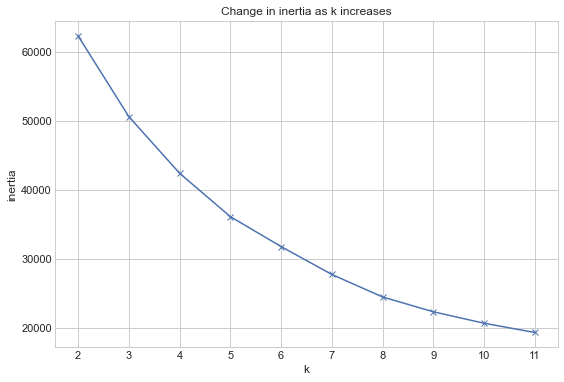

In [73]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

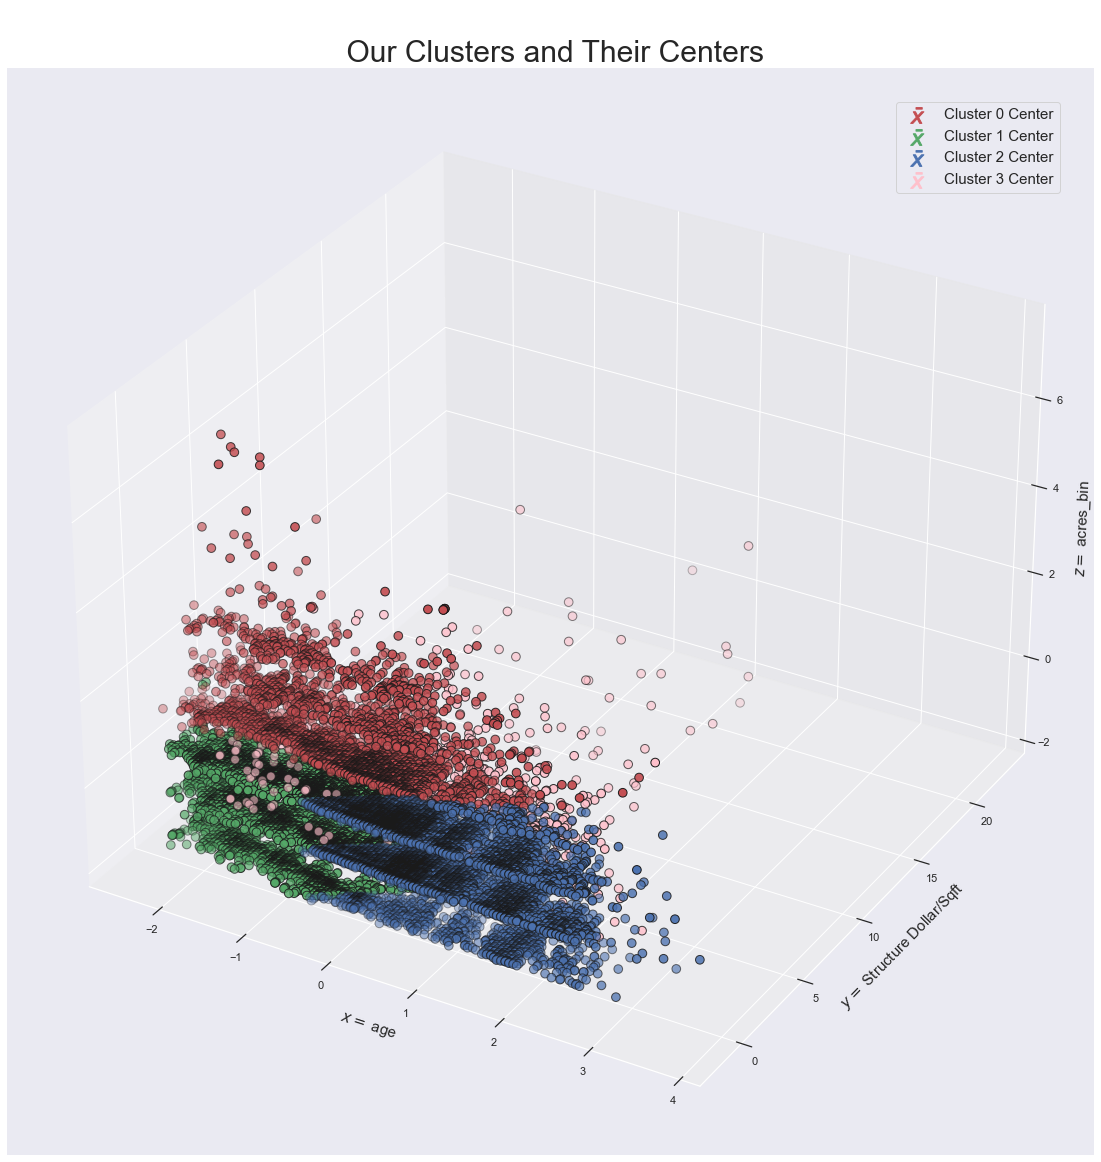

In [74]:
#%matplotlib osx
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

# set x for each cluster
x0 = X_train_scaled[X_train_scaled['clusterland'] == 0]['age']
x1 = X_train_scaled[X_train_scaled['clusterland'] == 1]['age']
x2 = X_train_scaled[X_train_scaled['clusterland'] == 2]['age']
x3 = X_train_scaled[X_train_scaled['clusterland'] == 3]['age']



# set y for each cluster
y0 = X_train_scaled[X_train_scaled['clusterland'] == 0]['structure_dollar_per_sqft']
y1 = X_train_scaled[X_train_scaled['clusterland'] == 1]['structure_dollar_per_sqft']
y2 = X_train_scaled[X_train_scaled['clusterland'] == 2]['structure_dollar_per_sqft']
y3 = X_train_scaled[X_train_scaled['clusterland'] == 3]['structure_dollar_per_sqft']


# set z for each cluster
z0 = X_train_scaled[X_train_scaled['clusterland'] == 0]['acres_bin']
z1 = X_train_scaled[X_train_scaled['clusterland'] == 1]['acres_bin']
z2 = X_train_scaled[X_train_scaled['clusterland'] == 2]['acres_bin']
z3 = X_train_scaled[X_train_scaled['clusterland'] == 3]['acres_bin']


#centroids
zero_center = centroids[centroids.index == 0]
one_center = centroids[centroids.index == 1]
two_center = centroids[centroids.index == 2]
three_center = centroids[centroids.index == 3]
four_center = centroids[centroids.index == 4]


# plot cluster 0 with center
ax.scatter(x0, y0, z0, s=75, c='r', edgecolor='k', marker='o')
ax.scatter(zero_center.age, zero_center.structure_dollar_per_sqft, zero_center.acres_bin, s=250, c='r', marker='$\\bar{x}$', label='Cluster 0 Center')
# plot cluster 1 with center
ax.scatter(x1, y1, z1, s=75, c='g', edgecolor='k', marker='o')
ax.scatter(one_center.age, one_center.structure_dollar_per_sqft, one_center.acres_bin, s=250, c='g', marker='$\\bar{x}$', label='Cluster 1 Center')
# plot cluster 2 with center
ax.scatter(x2, y2, z2, s=75, c='b', edgecolor='k', marker='o')
ax.scatter(two_center.age, two_center.structure_dollar_per_sqft, two_center.acres_bin, s=250, c='b', marker='$\\bar{x}$', label='Cluster 2 Center')
#plot cluster 3 with center
ax.scatter(x3, y3, z3, s=75, c='pink', edgecolor='k', marker='o')
ax.scatter(three_center.age, three_center.structure_dollar_per_sqft, three_center.acres_bin, s=250, c='pink', marker='$\\bar{x}$', label='Cluster 3 Center')


# set labels and title
ax.set_xlabel('\n$x =$ age', fontsize=15)
ax.set_ylabel('\n$y =$ Structure Dollar/Sqft', fontsize=15)
ax.set_zlabel('\n$z =$ acres_bin', fontsize=15)
plt.title('\n Our Clusters and Their Centers', fontsize=30)
plt.legend(bbox_to_anchor=(0.975,0.975), fontsize=15)
plt.show()

In [75]:
#add predictions to our train
train['clusterland'] = kmeans.predict(X)
train

,propertylandusetypeid,parcel_id,id,baths,beds,calculatedbathnbr,sqft,finishedsquarefeet12,fullbathcnt,latitude,...,acres_bin,sqft_bin,structure_dollar_per_sqft,cola,county,los_angeles,orange,ventura,cluster,clusterland
21968,261.0,17141268,1596440,2.0,3.0,2.0,1444.0,1444.0,2.0,34227068.0,...,0.2,0.3,34.391274,0,ventura,0,0,1,cluster_1,1
30440,261.0,12685224,2126367,2.0,3.0,2.0,1408.0,1408.0,2.0,33795720.0,...,0.2,0.3,29.988636,0,los_angeles,1,0,0,cluster_0,1
65736,261.0,12282209,334879,1.0,2.0,1.0,1161.0,1161.0,1.0,33935420.0,...,0.0,0.2,110.705426,0,los_angeles,1,0,0,cluster_0,3
67676,261.0,12829836,307355,2.0,4.0,2.0,2016.0,2016.0,2.0,33945022.0,...,0.2,0.5,35.534722,0,los_angeles,1,0,0,cluster_0,1
485,261.0,12586633,1991849,1.0,3.0,1.0,986.0,986.0,1.0,33860347.0,...,0.1,0.1,24.490872,0,los_angeles,1,0,0,cluster_0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37587,261.0,12664744,962986,2.0,5.0,2.0,1816.0,1816.0,2.0,33831612.0,...,0.1,0.4,30.999449,0,los_angeles,1,0,0,cluster_0,6
27171,261.0,11516323,1465655,3.0,4.0,3.0,2619.0,2619.0,3.0,33996591.0,...,0.1,0.6,144.375334,0,los_angeles,1,0,0,cluster_0,2
17426,261.0,13975831,1203830,2.5,5.0,2.5,2371.0,2371.0,2.0,33708885.0,...,0.1,0.5,37.152256,0,orange,0,1,0,cluster_2,6
13215,261.0,11318827,2627754,1.0,1.0,1.0,1056.0,1056.0,1.0,34671938.0,...,0.5,0.2,81.391098,0,los_angeles,1,0,0,cluster_1,9


In [76]:
#logerror of the different clusters
lcluster_0 = train[train.clusterland == 0].logerror #younger, smaller, cheaper
lcluster_1 = train[train.clusterland == 1].logerror #younger, larger, more expensive houses
lcluster_2 = train[train.clusterland == 2].logerror #older, medium, cheaper houses
lcluster_3 = train[train.clusterland == 3].logerror #most expensive houses, wide range of age and size


In [77]:
#Statistically significant differences in log error means between these features? 
from scipy.stats import f_oneway

f, p = f_oneway(lcluster_0,lcluster_1,lcluster_2,lcluster_3)
f,p

(9.219299213593262, 4.346837892347971e-06)

There is sufficient evidence to reject the null hypothesis, small p-value

Null Hypothesis: No difference in log error for houses based on longitude, latitude, and acre amount.

Alternative Hypothesis: There is a difference in log error for houses based on longitude, latitude, and acre amount.

In [78]:
X_features_2 = train[['longitude', 'latitude', 'acres_bin']]
X = X_train_scaled[['longitude', 'latitude', 'acres_bin']]

# define the thing
kmeans = KMeans(n_clusters=3)

# fit the thing
kmeans.fit(X)

# Use (predict using) the thing 
kmeans.predict(X)

X_train_scaled['cluster_loc'] = kmeans.predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X_features_2.columns)

In [79]:
# run several k-means, increment k with each iteration, and record the SSE:
kmeans_kwargs = {
             "init": "random",
              "n_init": 10,
              "max_iter": 300,
              "random_state":123,
    }
   
    # A list holds the SSE values for each k
sse = []
for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)

In [80]:
from kneed import DataGenerator, KneeLocator
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

kl.elbow

3

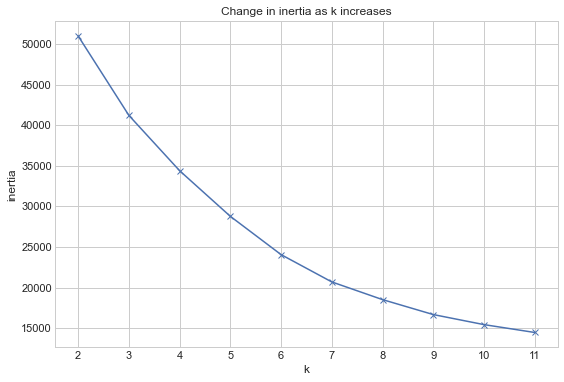

In [81]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

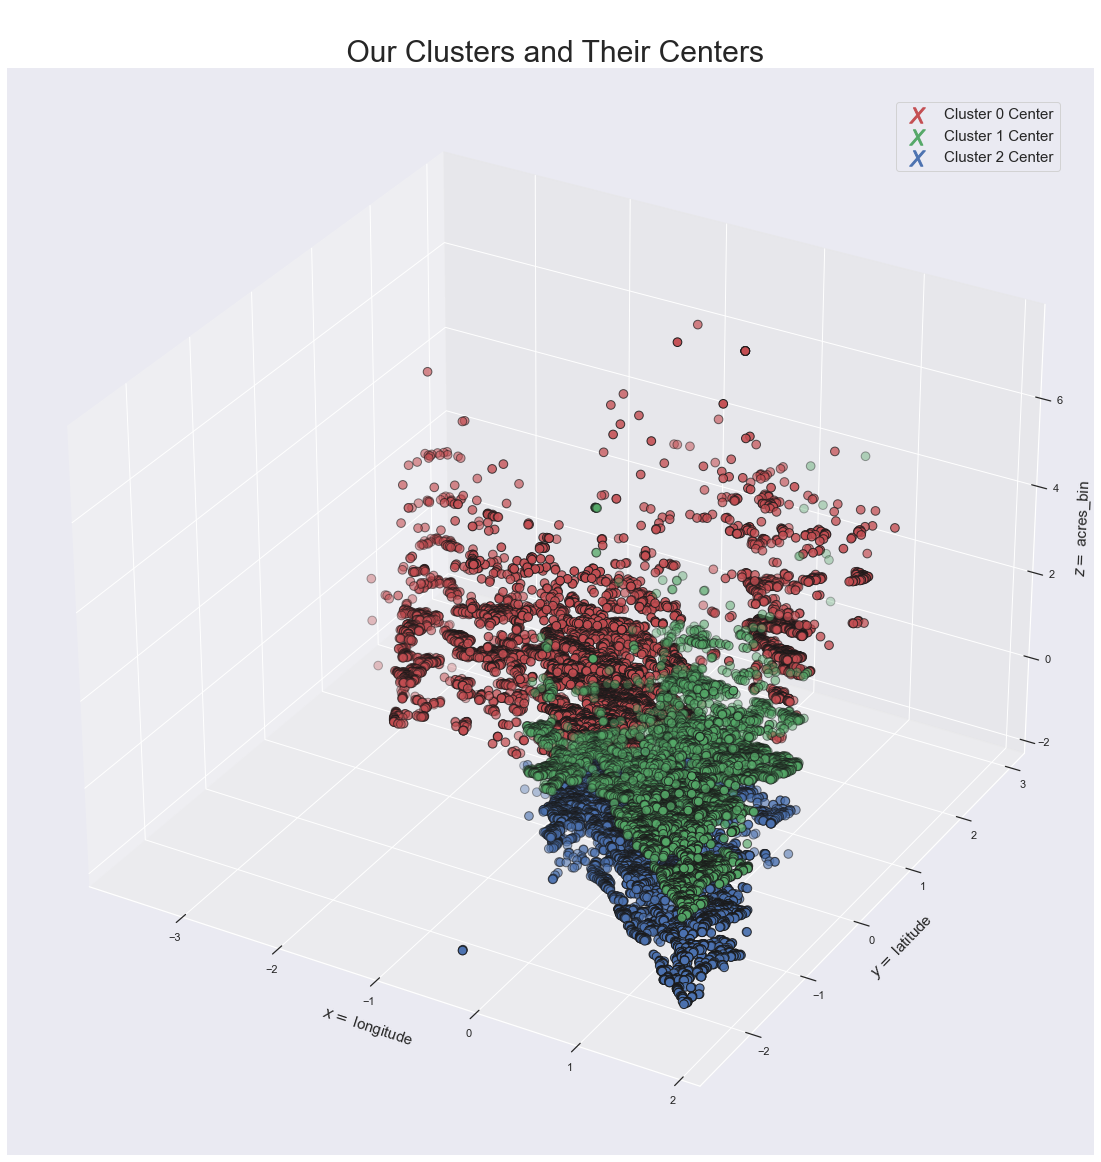

In [82]:
#%matplotlib osx
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

# set x for each cluster
x0 = X_train_scaled[X_train_scaled['cluster_loc'] == 0]['longitude']
x1 = X_train_scaled[X_train_scaled['cluster_loc'] == 1]['longitude']
x2 = X_train_scaled[X_train_scaled['cluster_loc'] == 2]['longitude']
x3 = X_train_scaled[X_train_scaled['cluster_loc'] == 3]['longitude']
x4 = X_train_scaled[X_train_scaled['cluster_loc'] == 4]['longitude']



# set y for each cluster
y0 = X_train_scaled[X_train_scaled['cluster_loc'] == 0]['latitude']
y1 = X_train_scaled[X_train_scaled['cluster_loc'] == 1]['latitude']
y2 = X_train_scaled[X_train_scaled['cluster_loc'] == 2]['latitude']
y3 = X_train_scaled[X_train_scaled['cluster_loc'] == 3]['latitude']
y4 = X_train_scaled[X_train_scaled['cluster_loc'] == 4]['latitude']



# set z for each cluster
z0 = X_train_scaled[X_train_scaled['cluster_loc'] == 0]['acres_bin']
z1 = X_train_scaled[X_train_scaled['cluster_loc'] == 1]['acres_bin']
z2 = X_train_scaled[X_train_scaled['cluster_loc'] == 2]['acres_bin']
z3 = X_train_scaled[X_train_scaled['cluster_loc'] == 3]['acres_bin']
z4 = X_train_scaled[X_train_scaled['cluster_loc'] == 4]['acres_bin']



zero_center = centroids[centroids.index == 0]
one_center = centroids[centroids.index == 1]
two_center = centroids[centroids.index == 2]




# plot cluster 0 with center
ax.scatter(x0, y0, z0, s=75, c='r', edgecolor='k', marker='o')
ax.scatter(zero_center.longitude, zero_center.latitude, zero_center.acres_bin, s=250, c='r', marker='$X$', label='Cluster 0 Center')
ax.scatter(x1, y1, z1, s=75, c='g', edgecolor='k', marker='o')
# plot cluster 1 with center
ax.scatter(one_center.longitude, one_center.latitude, one_center.acres_bin, s=250, c='g', marker='$X$', label='Cluster 1 Center')
# plot cluster 2 with center
ax.scatter(x2, y2, z2, s=75, c='b', edgecolor='k', marker='o')
ax.scatter(two_center.longitude, two_center.latitude, two_center.acres_bin, s=250, c='b', marker='$X$', label='Cluster 2 Center')


#
# set labels and title
ax.set_xlabel('\n$x =$ longitude', fontsize=15)
ax.set_ylabel('\n$y =$ latitude', fontsize=15)
ax.set_zlabel('\n$z =$ acres_bin', fontsize=15)
plt.title('\n Our Clusters and Their Centers', fontsize=30)
plt.legend(bbox_to_anchor=(0.975,0.975), fontsize=15)
plt.show()

In [83]:
#add location cluster predictions to train
train['cluster_loc'] = kmeans.predict(X)
train

,propertylandusetypeid,parcel_id,id,baths,beds,calculatedbathnbr,sqft,finishedsquarefeet12,fullbathcnt,latitude,...,sqft_bin,structure_dollar_per_sqft,cola,county,los_angeles,orange,ventura,cluster,clusterland,cluster_loc
21968,261.0,17141268,1596440,2.0,3.0,2.0,1444.0,1444.0,2.0,34227068.0,...,0.3,34.391274,0,ventura,0,0,1,cluster_1,1,8
30440,261.0,12685224,2126367,2.0,3.0,2.0,1408.0,1408.0,2.0,33795720.0,...,0.3,29.988636,0,los_angeles,1,0,0,cluster_0,1,4
65736,261.0,12282209,334879,1.0,2.0,1.0,1161.0,1161.0,1.0,33935420.0,...,0.2,110.705426,0,los_angeles,1,0,0,cluster_0,3,3
67676,261.0,12829836,307355,2.0,4.0,2.0,2016.0,2016.0,2.0,33945022.0,...,0.5,35.534722,0,los_angeles,1,0,0,cluster_0,1,6
485,261.0,12586633,1991849,1.0,3.0,1.0,986.0,986.0,1.0,33860347.0,...,0.1,24.490872,0,los_angeles,1,0,0,cluster_0,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37587,261.0,12664744,962986,2.0,5.0,2.0,1816.0,1816.0,2.0,33831612.0,...,0.4,30.999449,0,los_angeles,1,0,0,cluster_0,6,3
27171,261.0,11516323,1465655,3.0,4.0,3.0,2619.0,2619.0,3.0,33996591.0,...,0.6,144.375334,0,los_angeles,1,0,0,cluster_0,2,3
17426,261.0,13975831,1203830,2.5,5.0,2.5,2371.0,2371.0,2.0,33708885.0,...,0.5,37.152256,0,orange,0,1,0,cluster_2,6,0
13215,261.0,11318827,2627754,1.0,1.0,1.0,1056.0,1056.0,1.0,34671938.0,...,0.2,81.391098,0,los_angeles,1,0,0,cluster_1,9,1


In [84]:
#getting ready to test for significance
locluster_0 = train[train.cluster_loc == 0].logerror #likely new Orange County properties
locluster_1 = train[train.cluster_loc == 1].logerror #likely new Ventura County properties
locluster_2 = train[train.cluster_loc == 2].logerror #Older LA properties


In [85]:
#let's see if there's a difference in logerror means between properties based on latitude, longitude, and acreage.
from scipy.stats import f_oneway

f, p = f_oneway(locluster_0,locluster_1,locluster_2)
f,p

(3.1256134125802153, 0.04396399539940402)

There is sufficient evidence to reject the null hypothesis, the p value is .043

In [86]:
# Going to focus on cluster location for statistical significance due to smaller k value

In [87]:
#make a population mean for all location clusters
pop_mean = (locluster_0.mean()+locluster_1.mean()+locluster_2.mean())/3

In [88]:
#locluster_0 is not significant 
t,p = stats.ttest_1samp(locluster_0,pop_mean)
t,p

(1.6421327729682427, 0.10065276578613958)

In [89]:
#locluster_1 is not significant 
t,p = stats.ttest_1samp(locluster_1,pop_mean)
t,p

(-0.07013593360506645, 0.9441089921011676)

In [90]:
#locluster_2 is significant 
t,p = stats.ttest_1samp(locluster_2,pop_mean)
t,p

(-2.067293337670085, 0.03877294158315805)

In [91]:
#apply location cluster predictions to train, validate, and test sets.
X = X_train_scaled[['longitude', 'latitude', 'acres_bin']]
X_val = X_validate_scaled[['longitude', 'latitude', 'acres_bin']]
X_test_cols = X_test_scaled[['longitude', 'latitude', 'acres_bin']]
# define the thing
kmeans = KMeans(n_clusters=3)

# fit the thing
kmeans.fit(X)

# Use (predict using) the thing 
kmeans.predict(X)

train['cluster_loc'] = kmeans.predict(X)
validate['cluster_loc'] = kmeans.predict(X_val)
test['cluster_loc']= kmeans.predict(X_test_cols)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X_features.columns)

In [92]:
#make dummies for all sets based on our clusters
dummy_train = pd.get_dummies(train['cluster_loc'],drop_first=False)
dummy_validate = pd.get_dummies(validate['cluster_loc'],drop_first=False)
dummy_test = pd.get_dummies(test['cluster_loc'],drop_first=False)

In [93]:
#rename the columns
dummy_train.columns = ['locluster_0','locluster_1','locluster_2']
dummy_validate.columns = ['locluster_0','locluster_1','locluster_2']
dummy_test.columns = ['locluster_0','locluster_1','locluster_2']

In [94]:
#columns before concatenating 
train.columns

Index(['propertylandusetypeid', 'parcel_id', 'id', 'baths', 'beds',
       'calculatedbathnbr', 'sqft', 'finishedsquarefeet12', 'fullbathcnt',
       'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'rawcensustractandblock', 'regionidcity',
       'regionidzip', 'roomcnt', 'year_built', 'structuretaxvaluedollarcnt',
       'tax_value', 'assessmentyear', 'landtaxvaluedollarcnt', 'tax_amount',
       'censustractandblock', 'logerror', 'transactiondate',
       'propertylandusedesc', 'LA', 'Orange', 'Ventura', 'age', 'age_bin',
       'taxrate', 'acres', 'acres_bin', 'sqft_bin',
       'structure_dollar_per_sqft', 'cola', 'county', 'los_angeles', 'orange',
       'ventura', 'cluster', 'clusterland', 'cluster_loc'],
      dtype='object')

In [95]:
#concatenate, drop clusters we won't be using (until next time)
train= pd.concat((train,dummy_train),axis=1)
validate = pd.concat((validate, dummy_validate),axis=1)
test = pd.concat((test, dummy_test),axis=1)

In [96]:
#making sure that they show up
validate.columns

Index(['propertylandusetypeid', 'parcel_id', 'id', 'baths', 'beds',
       'calculatedbathnbr', 'sqft', 'finishedsquarefeet12', 'fullbathcnt',
       'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'rawcensustractandblock', 'regionidcity',
       'regionidzip', 'roomcnt', 'year_built', 'structuretaxvaluedollarcnt',
       'tax_value', 'assessmentyear', 'landtaxvaluedollarcnt', 'tax_amount',
       'censustractandblock', 'logerror', 'transactiondate',
       'propertylandusedesc', 'LA', 'Orange', 'Ventura', 'age', 'age_bin',
       'taxrate', 'acres', 'acres_bin', 'sqft_bin',
       'structure_dollar_per_sqft', 'cola', 'county', 'los_angeles', 'orange',
       'ventura', 'cluster_loc', 'locluster_0', 'locluster_1', 'locluster_2'],
      dtype='object')

In [97]:
#drop repetitive columns, and ones we won't be using.
train.drop(columns=['cluster_loc','clusterland'],inplace=True)
validate.drop(columns=['cluster_loc'],inplace=True)
test.drop(columns=['cluster_loc'],inplace=True)

In [98]:
#drop location clusters that were NOT significant
train=train.drop(columns=['locluster_0','locluster_1'])
validate = validate.drop(columns=['locluster_0','locluster_1'])
test = test.drop(columns=['locluster_0','locluster_1'])

In [99]:
#new X_train, y_train, X_validate, y_validate, X_test, y_test
X_train = train.drop(columns=['logerror'])
y_train = pd.DataFrame(train.logerror)
X_validate = validate.drop(columns=['logerror'])
y_validate = pd.DataFrame(validate.logerror)
X_test = test.drop(columns=['logerror'])
y_test = pd.DataFrame(test.logerror)

In [100]:
#get object columns, and numeric columns. Using numeric columns to scale.
obj_cols = get_object_cols(X_train)
num_cols = get_numeric_X_cols(X_train, obj_cols)

In [101]:
#scale the X's
X_train_scaled, X_validate_scaled, X_test_scaled = standard_scale_data(X_train[num_cols], X_validate[num_cols], X_test[num_cols])

## Feature Engineering

In [103]:
number_of_features_list=np.arange(1,40)
high_score=0

#Variable to store the optimum features
number_of_features=0           
score_list =[]

for n in range(len(number_of_features_list)):
    model = LinearRegression()
    rfe = RFE(model,number_of_features_list[n])
    X_train_rfe = rfe.fit_transform(X_train_scaled,y_train)
    X_test_rfe = rfe.transform(X_test_scaled)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        number_of_features = number_of_features_list[n]

print("Optimum number of features: %d" %number_of_features)
print("Score with %d features: %f" % (number_of_features, high_score))

Optimum number of features: 13
Score with 13 features: 0.003414


In [104]:
cols = list(X_train_scaled.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 13)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train_scaled,y_train)  

#Fitting the data to model
model.fit(X_rfe,y_train)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

Index(['baths', 'calculatedbathnbr', 'sqft', 'rawcensustractandblock', 'LA',
       'Orange', 'Ventura', 'sqft_bin', 'structure_dollar_per_sqft', 'cola',
       'los_angeles', 'orange', 'ventura'],
      dtype='object')


In [105]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, 5)

# fit the data using RFE
rfe.fit(X_train_scaled,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()
rfe_feature

['rawcensustractandblock', 'LA', 'Ventura', 'los_angeles', 'ventura']

In [106]:
# get the ranks
var_ranks = rfe.ranking_
# get the variable names
var_names = X_train_scaled.columns.tolist()
# combine ranks and names into a df for clean viewing
rfe_ranks_df = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
# sort the df by rank
rfe_ranks_df.sort_values('Rank')

,Var,Rank
23,LA,1
12,rawcensustractandblock,1
34,los_angeles,1
36,ventura,1
25,Ventura,1
3,baths,2
5,calculatedbathnbr,3
31,sqft_bin,4
6,sqft,5
35,orange,6


In [107]:
from sklearn.metrics import mean_squared_error, r2_score
#turning my y_train and y_validate to dataframes so we can append new columns
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

#logerror mean
logerror_pred_mean = y_train['logerror'].mean()
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean

#logerror_median
logerror_pred_median = y_train['logerror'].median()
y_train['logerror_pred_median'] = logerror_pred_median
y_validate['logerror_pred_median'] = logerror_pred_median

#RMSE of logerror_pred_mean
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean)**(1/2)

print('             BASELINE')
print('----------------------------------')
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 4), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))
print('----------------------------------')

#RMSE of logerror_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 4), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))
print('----------------------------------')
r2_baseline = r2_score(y_validate.logerror, y_validate.logerror_pred_mean)
print(f'The r^2 score for baseline is {round(r2_baseline,3)}')

             BASELINE
----------------------------------
RMSE using Mean
Train/In-Sample:  0.1718 
Validate/Out-of-Sample:  0.1605
----------------------------------
RMSE using Median
Train/In-Sample:  0.1721 
Validate/Out-of-Sample:  0.1608
----------------------------------
The r^2 score for baseline is -0.0


In [108]:
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_mean)}])

In [109]:
# a list of my selected features 
selected_features = ['locluster_2','acres_bin','structure_dollar_per_sqft','los_angeles','ventura','orange']

In [110]:
#Our first model: LinearRegression
#create model object
lm = LinearRegression(normalize=True)

#fit the model to our training data, specify column since it is a dataframe
lm.fit(X_train_scaled[selected_features],y_train.logerror)

#predict train
y_train['logerror_pred_lm'] = lm.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(1/2)

#predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression:\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_lm = r2_score(y_validate.logerror, y_validate.logerror_pred_lm)
print(f'The r^2 value for linear regression is {round(r2_score_lm,3)}')

RMSE for OLS using LinearRegression:
Training/In-Sample:  0.1717031141555833 
Validation/Out-of-Sample:  0.16024762744978469
The r^2 value for linear regression is 0.003


In [111]:
metric_df = metric_df.append(
    {
    'model': 'OLS lm 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lm)}, ignore_index=True)

In [112]:
#create model object
lars = LassoLars(alpha=1.0)

#fit the model to our training data, specify column since it is a dataframe
lars.fit(X_train_scaled[selected_features],y_train.logerror)

#predict train
y_train['logerror_pred_lars'] = lars.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(1/2)

#predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(1/2)

print("RMSE for OLS using LassoLars:\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_lars = r2_score(y_validate.logerror, y_validate.logerror_pred_lars)
print(f'The r^2 value for LassoLars regression is {round(r2_score_lars,3)}')

RMSE for OLS using LassoLars:
Training/In-Sample:  0.1718308137461203 
Validation/Out-of-Sample:  0.16046855559273324
The r^2 value for LassoLars regression is -0.0


In [113]:
metric_df = metric_df.append(
    {
    'model': 'LassoLars alpha = 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lars)}, ignore_index=True)

In [114]:
#TweedieRegressor
#create model object
glm = TweedieRegressor(power = 0,alpha=1.0)

#fit the model to our training data, specify column since it is a dataframe
glm.fit(X_train_scaled[selected_features],y_train.logerror)

#predict train
y_train['logerror_pred_glm'] = glm.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm)**(1/2)

#predict validate
y_validate['logerror_pred_glm'] = glm.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_glm)**(1/2)

print("RMSE for OLS using TweedieRegressor:\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_glm = r2_score(y_validate.logerror, y_validate.logerror_pred_glm)
print(f'The r^2 value for TweedieRegressor regression is {round(r2_score_glm,3)}')

RMSE for OLS using TweedieRegressor:
Training/In-Sample:  0.1717287974270537 
Validation/Out-of-Sample:  0.1603283151189379
The r^2 value for TweedieRegressor regression is 0.002


In [115]:
metric_df = metric_df.append(
    {
    'model': 'GLM Model power 0',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_glm)}, ignore_index=True)

In [124]:
from sklearn.preprocessing import PolynomialFeatures

#making polynomial features to get a new set of features, I found that degree=3 yielded the best results.
pf = PolynomialFeatures(degree=3)

#fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train_scaled[selected_features])

#transform X_validate_scaled, and X_test_scaled
X_validate_degree3 = pf.transform(X_validate_scaled[selected_features])
X_test_degree3 = pf.transform(X_test_scaled[selected_features])

#linear regresson with 3 degrees
lm3 = LinearRegression(normalize=True)

#fit the model to our training data, specify column since it is a dataframe
lm3.fit(X_train_degree3,y_train.logerror)

#predict train
y_train['logerror_pred_lm3'] = lm3.predict(X_train_degree3)

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2)**(1/2)

#predict validate
y_validate['logerror_pred_lm3'] = lm3.predict(X_validate_degree3)

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm3)**(1/2)

print("RMSE for OLS using Polynomial Regression (3 degrees):\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_lm3 = r2_score(y_validate.logerror, y_validate.logerror_pred_lm3)
print(f'The r^2 value for Polynomial Regression (3 degrees) is {round(r2_score_lm3,3)}')

RMSE for OLS using Polynomial Regression (3 degrees):
Training/In-Sample:  0.1715241922994094 
Validation/Out-of-Sample:  0.1603515382517995
The r^2 value for Polynomial Regression (2 degrees) is 0.001


In [127]:
metric_df = metric_df.append(
    {
    'model': 'Cubic Model',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lm3)}, ignore_index=True)

In [128]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,0.160812,2.220446e-16
1,OLS lm 1,0.160248,2.751421e-03
2,LassoLars alpha = 1,0.160469,0.000000e+00
3,GLM Model power 0,0.160328,1.746998e-03
4,Cubic Model,0.160352,1.458310e-03
5,Cubic Model,0.160352,1.458310e-03


Text(0.5, 1.0, 'Residuals')

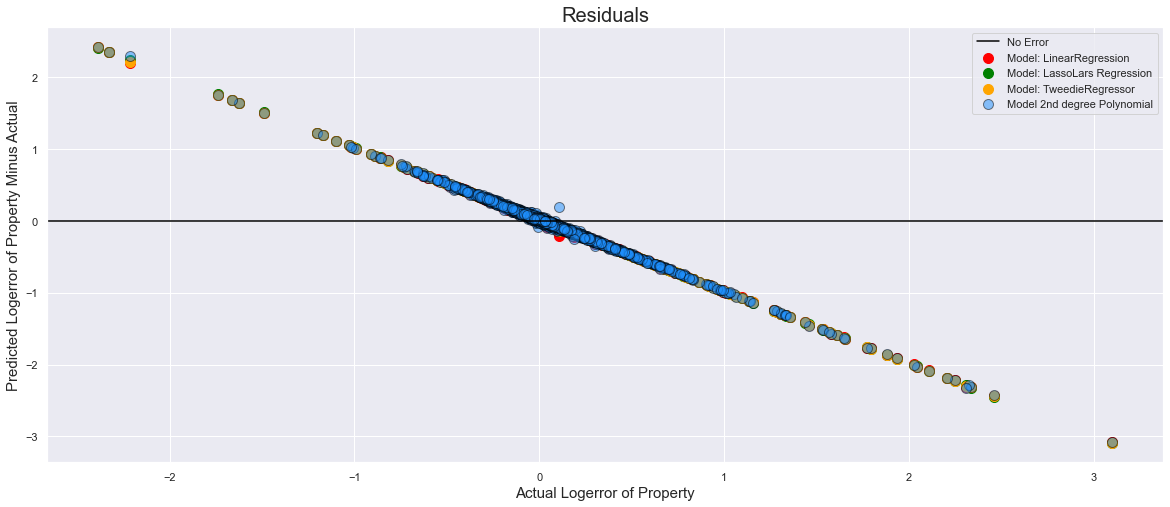

In [129]:
plt.figure(figsize=(20,8))
plt.axhline(label="No Error", color="black")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm-y_validate.logerror, 
            alpha=1, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lars-y_validate.logerror, 
            alpha=1, color="green", s=100, label="Model: LassoLars Regression")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_glm-y_validate.logerror, 
            alpha=1, color="orange", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm2-y_validate.logerror, 
            alpha=.5, color="dodgerblue", s=100, edgecolors='black', label="Model 2nd degree Polynomial")
plt.legend()

plt.xlabel("Actual Logerror of Property", fontdict={'fontsize':15})
plt.ylabel("Predicted Logerror of Property Minus Actual", fontdict={'fontsize':15})
plt.title("Residuals", fontdict={'fontsize': 20})

Not much difference between the model types. The quadratic model has the lowest RMSE. We will set up a test for it.

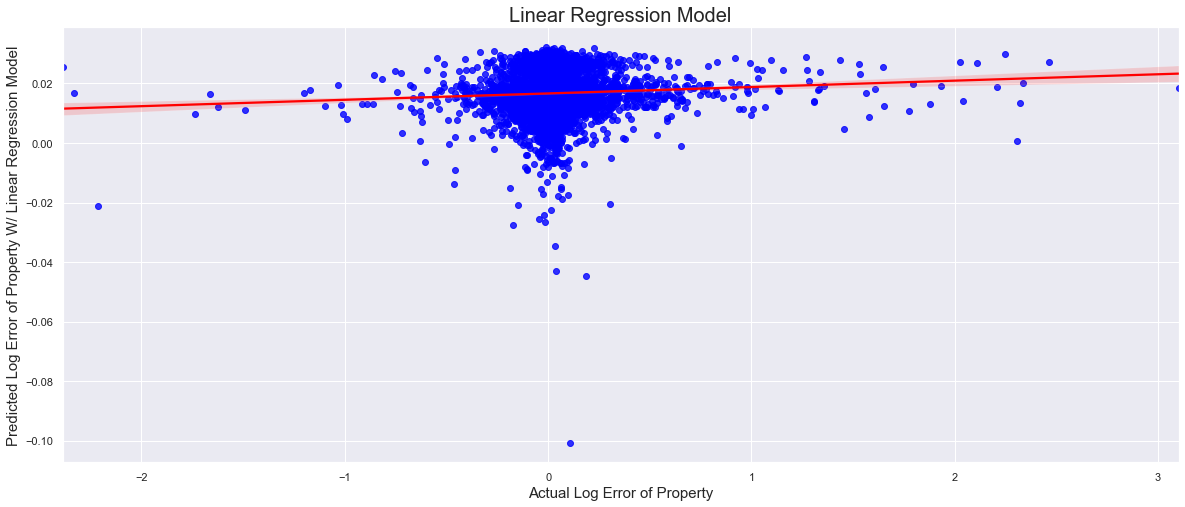

In [130]:
#looks like 3rd degree polynomial did the best, let's visualize that
plt.figure(figsize=(20,8))

sns.regplot(data=y_test, x=y_validate.logerror, y=y_validate.logerror_pred_lm, 
            scatter_kws={'color':'blue'}, line_kws={'color':'red'})
plt.xlabel("Actual Log Error of Property", fontdict={'fontsize':15})
plt.ylabel("Predicted Log Error of Property W/ Linear Regression Model", fontdict={'fontsize':15})
plt.title("Linear Regression Model", fontdict={'fontsize': 20})

plt.show()

In [131]:
#turning it into a dataframe
y_test = pd.DataFrame(y_test)

# predicting on our test model
y_test['logerror_pred_lm3'] = lm3.predict(X_test_degree3)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_lm3)**(1/2)
print('             ')
print('             Our Test Model')
print('----------------------------------')
print('----------------------------------')
print(f"RMSE for Quadratic Model \nOut-of-Sample Performance: ", round(rmse_test,3))
r2_test_score_lm = r2_score(y_test.logerror, y_test.logerror_pred_lm3)
print(f'Quadratic Model has an R^2 value of {round(r2_test_score_lm,3)}')


print('Our baseline score was 0.160')

             
             Our Test Model
----------------------------------
----------------------------------
RMSE for Quadratic Model 
Out-of-Sample Performance:  0.174
Quadratic Model has an R^2 value of 0.002
Our baseline score was 0.163


# Conclusion and Next Steps



My model did not beat the baseline
Ended with an RMSE of 0.174, and an R^2 of 0.002

I should try using the other clusters I made, or try clustering different features